In [1]:
# read the file 'dataset_reg_pair_filled.csv' and generate synthetic data
# first read the file, then make a list of the source training images
# then for each image, generate 10 synthetic images with random affine transformation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from utils.SuperPoint import SuperPointFrontend, PointTracker
from utils.utils1 import overlay_points

# read the file
df = pd.read_csv('Dataset/dataset_reg_pair_filled.csv')
print(df.shape)
df.head()

(5040, 9)


,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory
0,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b1.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
1,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
2,2011248_20161215__L_b1.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lb
3,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc
4,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc


In [2]:
# make a list of the unique source training images that has 'training' = 0
# each image path consists of image directory, image name

df_train = df[df['training'] == 0]

# create a new df consists of image directory and image name concatenated
df_train['image_path'] = df_train['Directory'] + '/' + df_train['source']
df_train.head()


/tmp/ipykernel_28462/1623562252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['image_path'] = df_train['Directory'] + '/' + df_train['source']


,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,image_path
3,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
4,2011248_20161215__L_c2.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
5,2011248_20161215__L_c1.jpg,NaN,2011248_20161215__L_c3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Lc,Dataset/Dataset-processed/15-12-2559/2011248/L...
6,2011248_20161215__R_b2.jpg,NaN,2011248_20161215__R_b3.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rb,Dataset/Dataset-processed/15-12-2559/2011248/R...
7,2011248_20161215__R_b2.jpg,NaN,2011248_20161215__R_b1.jpg,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rb,Dataset/Dataset-processed/15-12-2559/2011248/R...


In [3]:
print(df_train.shape)
# make a list of the unique values in the column 'image_path'

image_list = df_train['image_path'].unique()
print(len(image_list))
print(image_list[0])


(4132, 10)
920
Dataset/Dataset-processed/15-12-2559/2011248/Lc/2011248_20161215__L_c2.jpg


In [4]:
def tensor_affine_transform(tensor, tensor_transform):
    """
    Applies an affine transformation to a tensor.

    Args:
        tensor (torch.Tensor): The input tensor to transform.
        tensor_transform (torch.Tensor): The affine transformation matrix.

    Returns:
        torch.Tensor: The transformed tensor.
    """
    affine_grid = F.affine_grid(tensor_transform, tensor.size(), align_corners=False)
    transformed_tensor = F.grid_sample(tensor, affine_grid, align_corners=False)
    return transformed_tensor


def transform_to_displacement_field(tensor, tensor_transform, device='cpu'):
    """
    Transforms a tensor using an affine transformation matrix and returns the corresponding displacement field.

    Args:
        tensor (torch.Tensor): The input tensor to transform, with shape (batch_size, channels, height, width).
        tensor_transform (torch.Tensor): The affine transformation matrix, with shape (batch_size, 2, 3).
        device (str, optional): The device to use for the computation (default: 'cpu').

    Returns:
        torch.Tensor: The displacement field tensor, with shape (2, height, width).
    """
    # function code here
    y_size, x_size = tensor.size(2), tensor.size(3)
    deformation_field = F.affine_grid(tensor_transform, tensor.size())
    gy, gx = torch.meshgrid(torch.arange(y_size), torch.arange(x_size))
    gy = gy.type(torch.FloatTensor).to(device)
    gx = gx.type(torch.FloatTensor).to(device)
    grid_x = (gx / (x_size - 1) - 0.5) * 2
    grid_y = (gy / (y_size - 1) - 0.5) * 2
    u_x = deformation_field[0, :, :, 0] - grid_x
    u_y = deformation_field[0, :, :, 1] - grid_y
    u_x = u_x / 2 * (x_size - 1)
    u_y = u_y / 2 * (y_size - 1)
    displacement_field = torch.cat((u_x.view(1, y_size, x_size), u_y.view(1, y_size, x_size)), dim=0)
    return displacement_field

# def landmark_transformer(landmark, pred):
#     """
#     Transform landmarks by displacement field using SimpleITK.

#     :param landmark: (N*2) array of landmarks
#     :param pred: displacement field of x, y axes (image size)
#     :return: landmarks transformed by the displacement field U, V
#     """
#     DVF = np.array(pred)
#     # print(DVF.shape)
#     U = -1 * DVF[0, :, :]
#     V = -1 * DVF[1, :, :]
#     DVF = np.zeros((pred.size(-1), pred.size(-1), 2))
#     DVF[:, :, 0] = U
#     DVF[:, :, 1] = V
#     width = U.shape[1]
#     height = U.shape[0]
#     landmark = np.array(landmark)

#     # ref: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/22_Transforms
#     # and https://github.com/SimpleITK/SimpleITK/issues/532
#     displacement = sitk.DisplacementFieldTransform(2)
#     field_size = [width, height]
#     field_origin = [0.0, 0.0]
#     field_spacing = [1, 1]
#     field_direction = [1, 0, 0, 1]

#     # Concatenate all the information into a single list
#     displacement.SetFixedParameters(field_size + field_origin + field_spacing + field_direction)
#     # Set the interpolator, either sitkLinear which is default or nearest neighbor
#     displacement.SetInterpolator(sitk.sitkNearestNeighbor)

#     # Displacement field from VM
#     originalDisplacements = np.stack((U, V), axis=-1).flatten().tolist()

#     coordsX = landmark[:, 0]
#     coordsY = landmark[:, 1]
#     originalDisplacements = [1 * x for x in originalDisplacements]
#     pointsX = []
#     pointsY = []
#     displacement.SetParameters(originalDisplacements)

#     for index, value in np.ndenumerate(coordsX):
#         px, py = displacement.TransformPoint((value, coordsY[index]))
#         pointsX.append(px)
#         pointsY.append(py)
#     return np.stack((pointsX, pointsY), axis=-1)



In [5]:
superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=0.7, cuda=True)

def transform_points(points, M):
    # M[1][0]: x translation
    # M[1][1]: y translation
    # M[0]: rotation
    # M[2]: shear
    # M[3][0]: x scale
    # M[3][1]: y scale

    affine_params = np.array([[M[0], M[1][0], M[1][1]], [M[2], M[3][0], M[3][1]]])

    affine_params = torch.tensor(affine_params).double()
    # Convert points to tensor
    points = torch.tensor(points).double()
    # reshape points tensor to (2, N) shape
    points = points.reshape(2, -1)


    # Add row of ones to points tensor
    ones = torch.ones(points.shape[1], device=points.device).unsqueeze(0)
    points = torch.cat((points, ones), dim=0)

    # Apply affine transformation
    # print(points.shape, points)
    print('unsqueezed: ', affine_params.squeeze(0)) 
    transformed_points = torch.mm(affine_params.squeeze(0), points)

    # Remove last row of ones
    # transformed_points = transformed_points[:2, :]
    # print('transformed_points: ', transformed_points.shape)

    return transformed_points

In [6]:
min_translation = 0.0  # Minimum translation in pixels
max_translation = 0.0  # Maximum translation in pixels
max_rotation = 0  # Maximum rotation in degrees
max_shear = 0  # Maximum shear in degrees
min_scale = 0.9  # Minimum scale factor
max_scale = 1.0  # Maximum scale factor

(0.0, (0, 0), 0.9702108502388, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9702, 0.0000, 0.0000]], dtype=torch.float64)


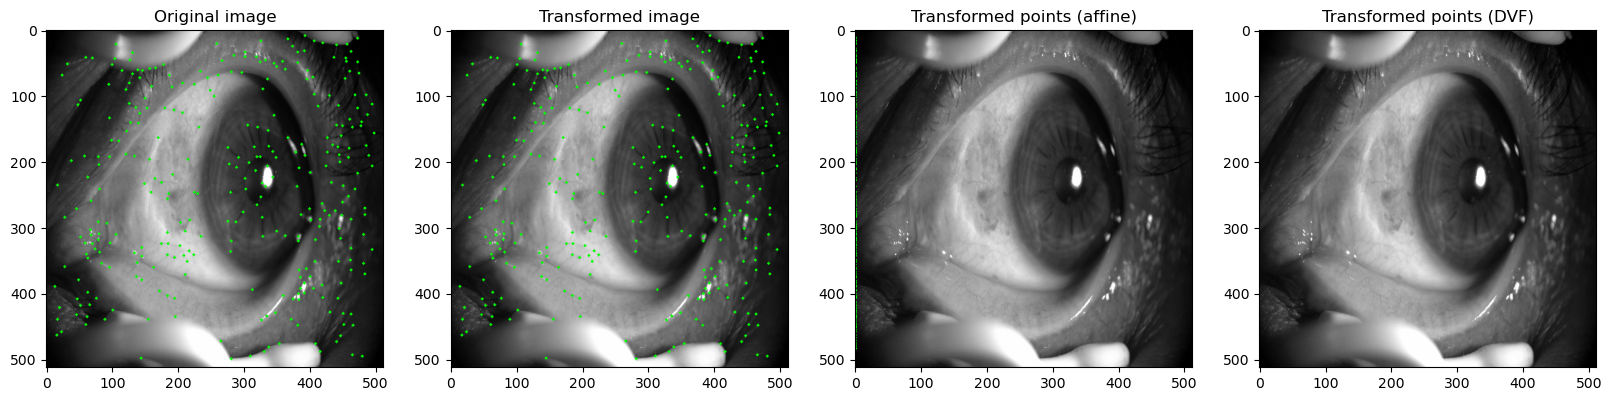

(0.0, (0, 0), 0.9469358325004578, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9469, 0.0000, 0.0000]], dtype=torch.float64)


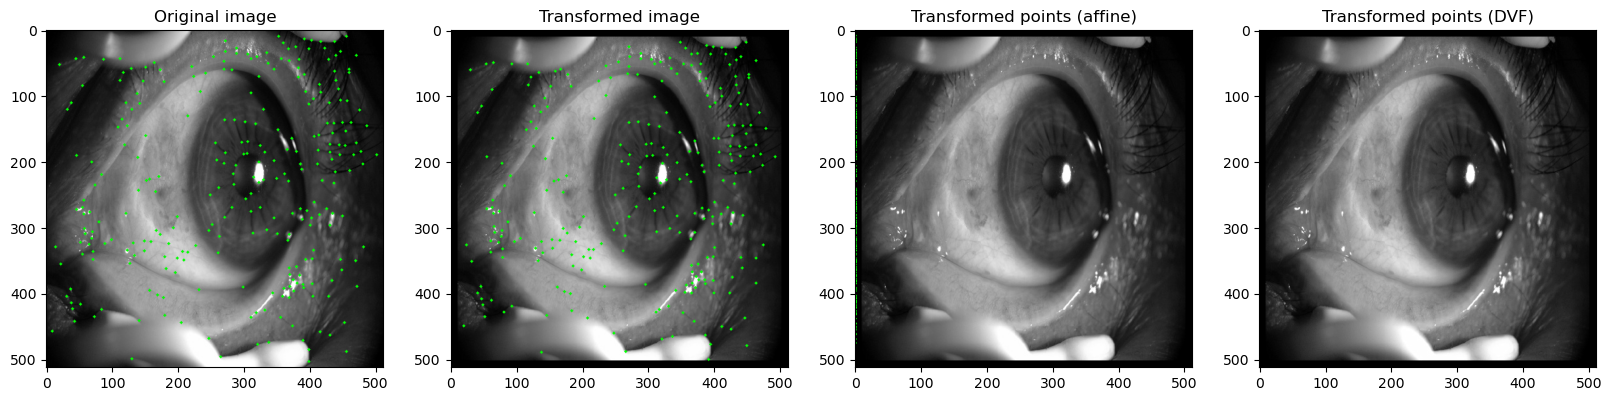

(0.0, (0, 0), 0.9335419535636902, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9335, 0.0000, 0.0000]], dtype=torch.float64)


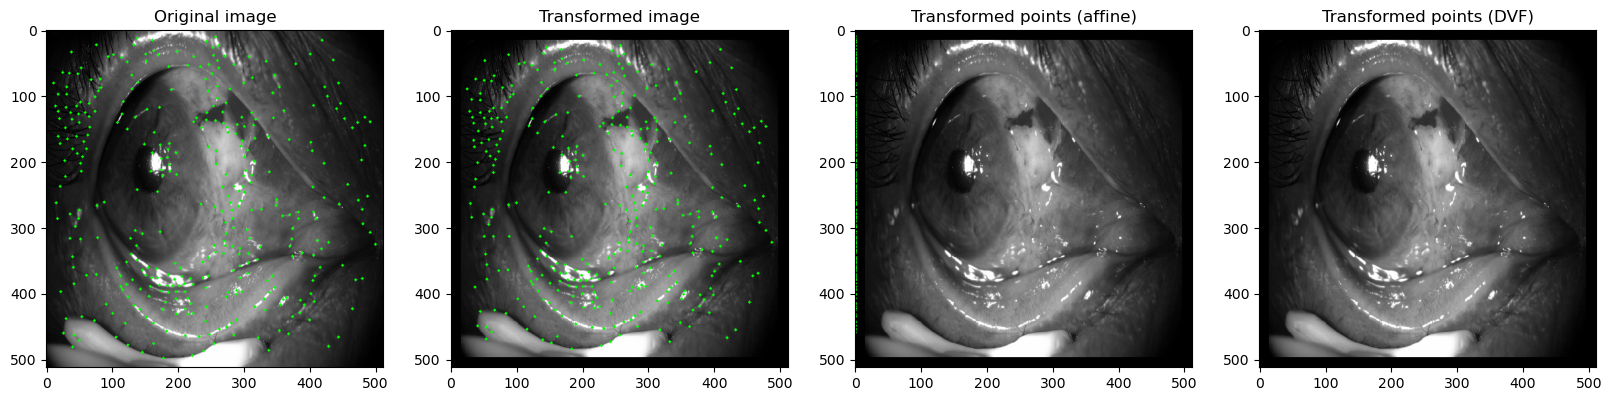

(0.0, (0, 0), 0.9880496263504028, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9880, 0.0000, 0.0000]], dtype=torch.float64)


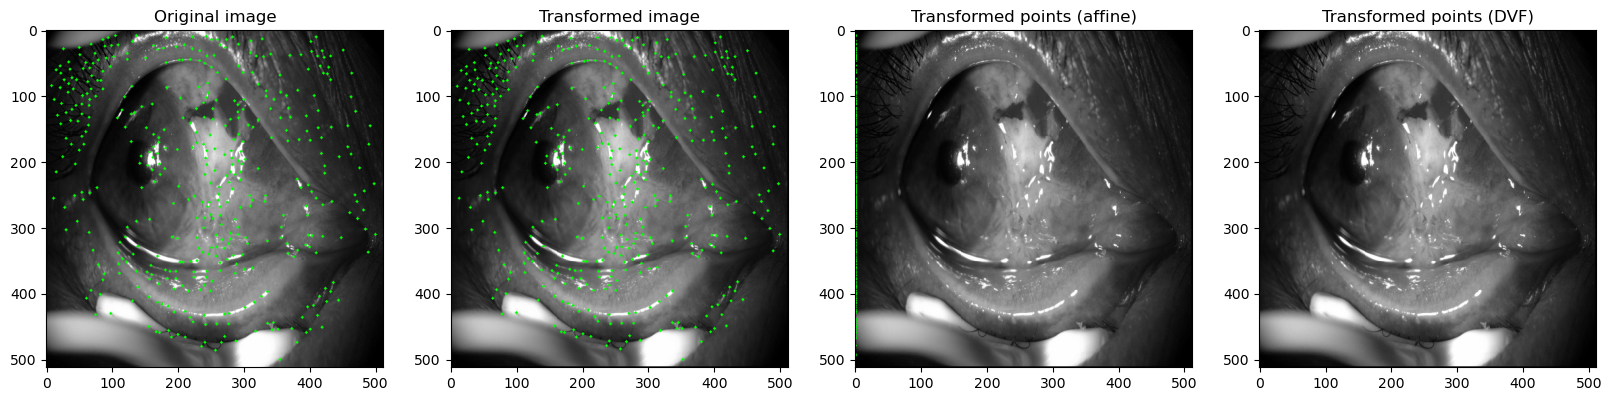

(0.0, (0, 0), 0.9079253673553467, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9079, 0.0000, 0.0000]], dtype=torch.float64)


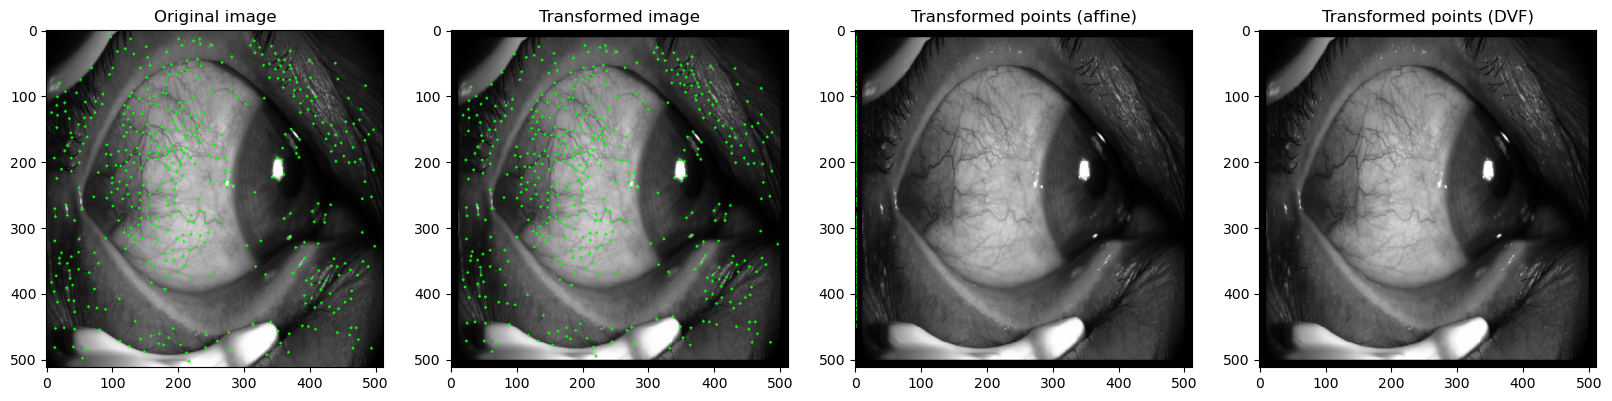

(0.0, (0, 0), 0.9162765741348267, (0.0, 0.0))
unsqueezed:  tensor([[0.0000, 0.0000, 0.0000],
        [0.9163, 0.0000, 0.0000]], dtype=torch.float64)


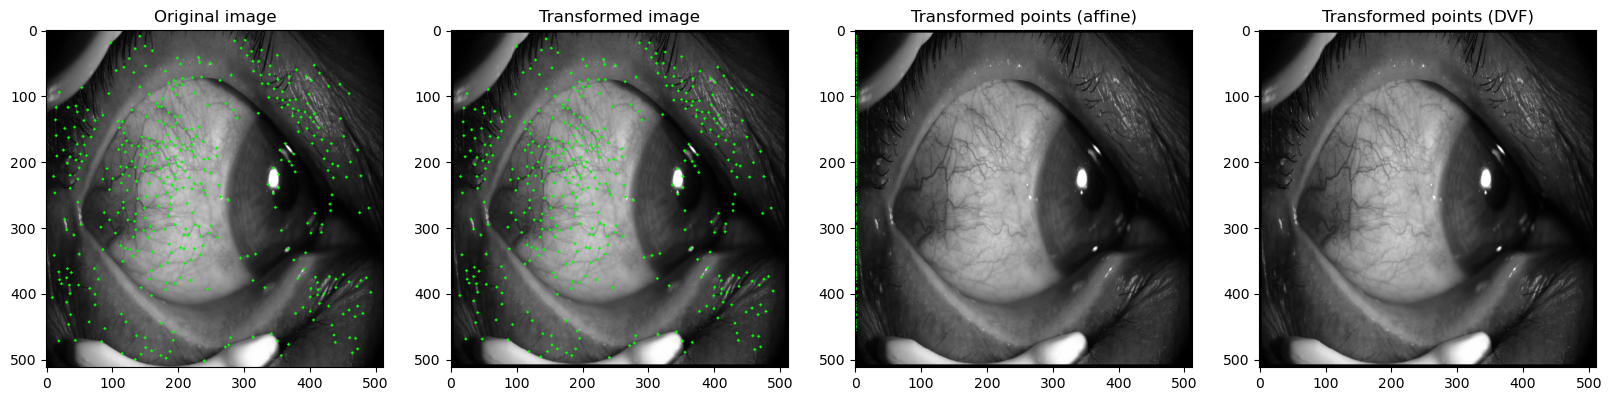

In [7]:
# Define parameters
size = 256  # Size of the images
image_size = (size, size)  # Size of the images
output_dir = "Dataset/synthetic_eye_dataset_train"  # Output directory
os.makedirs(output_dir, exist_ok=True)

# plot_dir = "Dataset/synthetic_eye_dataset_train/plot"
# os.makedirs(plot_dir, exist_ok=True)

# generate synthetic images for each source training image
# generate_affine_transformed_images_multiple(image_list,'Dataset/dataset_eye_synth_train.csv', output_dir, num_images=1, modify=True)

# Define the affine transformation
affine_transform = transforms.RandomAffine(degrees=(-max_rotation, max_rotation), translate=(min_translation, max_translation),
                                            shear=(-1*max_shear, max_shear), scale=(min_scale, max_scale))

# Loop over the images, read the image, 
# apply affine transformation and save it
for i, img_path in enumerate(image_list):
    # skip if the number is even
    if i > 5:
        break

    # Read the image as grayscale using cv2
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply affine transformation using PyTorch
    img_transformed = np.array(affine_transform(Image.fromarray(image)))
    
    points1, desc1, heatmap1 = superpoint(image.astype(np.float32)/255)
    points2, desc2, heatmap2 = superpoint(img_transformed.astype(np.float32)/255)

    # Convert the transformed image to a numpy array
    img_transformed = np.array(img_transformed)

    tracker = PointTracker(5, nn_thresh=0.7)
    matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=0.7)

    matches1 = points1[:2, matches[0, :].astype(int)]
    matches2 = points2[:2, matches[1, :].astype(int)]

    # Save the affine parameters to a CSV file
    # ref: https://programtalk.com/python-more-examples/torchvision.transforms.RandomAffine.get_params/
    M = affine_transform.get_params(degrees=(-max_rotation, max_rotation), translate=(min_translation, max_translation),
                                    scale_ranges=(min_scale, max_scale), shears=(-1*max_shear, max_shear), img_size=image.shape)
    print(M)
    
    # transform the points using the affine parameters
    matches1_transformed = transform_points(matches1.T[None, :, :], M)

    overlaid1 = overlay_points(image.copy(), matches1, radius=2)
    overlaid2 = overlay_points(img_transformed.copy(), matches2, radius=2)
    overlaid1to2 = overlay_points(img_transformed.copy(), matches1_transformed, radius=2)

    fig, axes = plt.subplot_mosaic("ABCD", figsize=(20, 5))
    axes['A'].imshow(overlaid1)
    axes['A'].set_title("Original image")
    axes['B'].imshow(overlaid2)
    axes['B'].set_title("Transformed image")
    axes['C'].imshow(overlaid1to2)
    axes['C'].set_title("Transformed points (affine)")
    axes['D'].imshow(img_transformed, cmap='gray')
    axes['D'].set_title("Transformed points (DVF)")

    plt.show()

In [8]:
# # Define parameters
# image_size = (512, 512)  # Size of the images
# output_dir = "Dataset/synthetic_eye_dataset_train_multiple"  # Output directory
# os.makedirs(output_dir, exist_ok=True)

# # plot_dir = "Dataset/synthetic_eye_dataset_train_multiple/plot"
# # os.makedirs(plot_dir, exist_ok=True)


# # generate synthetic images for each source training image
# generate_affine_transformed_images_multiple(image_list,'dataset_eye_synth_train_multiple.csv', output_dir, num_images=2, modify=True)

In [9]:
# do the same for the test images
df_test = df[df['training'] == 1]
df_test['image_path'] = df_test['Directory'] + '/' + df_test['source']
image_list_test = df_test['image_path'].unique()

# Define parameters
image_size = (size, size)  # Size of the images
output_dir = "Dataset/synthetic_eye_dataset_test"  # Output directory
os.makedirs(output_dir, exist_ok=True)

# plot_dir = "Dataset/synthetic_eye_dataset_test/plot"
# os.makedirs(plot_dir, exist_ok=True)

# generate synthetic images for each source test image
# generate_affine_transformed_images_multiple(image_list_test, 'Dataset/dataset_eye_synth_test.csv', output_dir, num_images=1)



/tmp/ipykernel_28462/4076406151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['image_path'] = df_test['Directory'] + '/' + df_test['source']


In [10]:
# # Define parameters
# image_size = (512, 512)  # Size of the images
# output_dir = "Dataset/synthetic_eye_dataset_test_multiple"  # Output directory
# os.makedirs(output_dir, exist_ok=True)

# # plot_dir = "Dataset/synthetic_eye_dataset_test/plot"
# # os.makedirs(plot_dir, exist_ok=True)

# # generate synthetic images for each source test image
# generate_affine_transformed_images_multiple(image_list_test, 'dataset_eye_synth_test_multiple.csv', output_dir, num_images=2)